In [214]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import math

plt.style.use('ggplot')

In [310]:
n = 1000
t0 = 0
t1 = 10

x = [np.random.normal() for _ in range(n)]
t = np.linspace(t0, t1, n)

x_u = [np.random.uniform(-1, 1) for _ in range(n)]

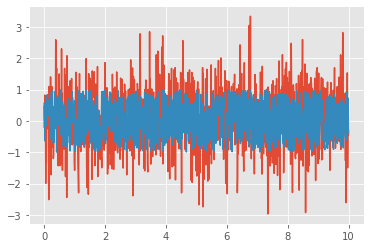

In [218]:
plt.plot(t, x)
plt.plot(t, x_u)

In [348]:
σ = 1
α = 1
D = 0.5

dt = (t1 - t0) / n

In [349]:
def get_R(D, α):
    def R(τ):
        return D * np.exp(-α * abs(τ)) * (1 - α * abs(τ))
    
    return R

def get_h(D, α, σ):
    def h(τ):
        return np.exp(-α * τ) * (1 - α * τ) * np.sqrt((2 * D * α) / (math.pi * σ**2))
    
    return h

In [350]:
h = get_h(D, α, σ)

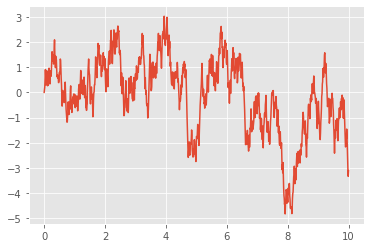

In [366]:
n = 1000
t0 = 0
t1 = 10
dt = (t1 - t0) / n

ys = []

for q in range(1):
    if not q: t = np.linspace(t0, t1, n)
    x = [np.random.uniform(-1, 1) for _ in range(n)]
    y = [sum(h(t0 + dt * i) * x[j - i] for i in range(j)) for j in range(n)]
    
    ys.append(y)
    
    plt.plot(t, y)
    #plt.plot(t, x)

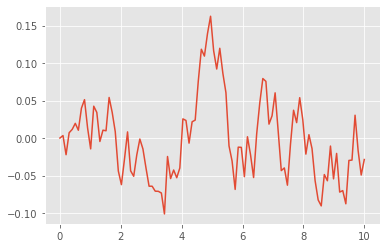

In [362]:
ys = np.array(ys)
mys = [np.mean(ys[:, i]) for i in range(n)]

plt.plot(t, mys)

In [346]:
def emp_R(y, dt, n):
    r_vals = []
    for k in range(n):
        lim = n - k
        r_vals.append((1 / lim) * sum(y[i] * y[i + k] for i in range(lim)))
    
    return r_vals
  
def theor_R(R, dt, n):
    return [R(dt * i) for i in range(n)]

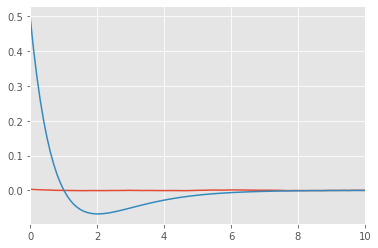

In [363]:
R = get_R(D, α)
emp_r = emp_R(y, dt, n)
th_R = theor_R(R, dt, n)

plt.xlim((t0, 10))
plt.plot(t, emp_r)
plt.plot(t, th_R)

In [360]:
np.mean(np.array(y)**2)

0.00017178134569376176

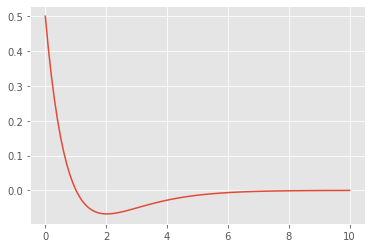

In [343]:
plt.plot(t, th_R)

In [367]:
x

[0.6408697370811256,
 0.19996793463525786,
 0.18560821064750255,
 0.6753486664958854,
 0.5786140645457751,
 -0.3945631217646779,
 -0.6340794861377586,
 0.20455240793513263,
 0.8355390939466145,
 -0.5791009136853347,
 0.5163157163297567,
 -0.9287584970543297,
 0.5919841358891134,
 -0.5361382352310338,
 0.35733912987612415,
 0.7440072320664166,
 0.17291198829369936,
 -0.1999924080878206,
 -0.3789701770484517,
 -0.4429432801602724,
 0.8293269007659538,
 0.12274981888465497,
 -0.06170284767129641,
 -0.23878786149745146,
 0.6568926728242861,
 0.787278910570284,
 0.3902120463090162,
 -0.5912130957507764,
 0.08013471945918593,
 0.12173179001579415,
 0.357377929879807,
 -0.5731117528135521,
 0.6259988490054234,
 0.5026421164999761,
 0.7361209023690138,
 -0.9079273356507203,
 -0.5260329321172867,
 -0.33621460195432284,
 0.8427931092528074,
 -0.3681528267007115,
 0.2320085329248891,
 -0.518734015010266,
 -0.5619059274897069,
 0.0975145900848402,
 -0.15106979152890854,
 0.10644871795061195,
 0.14

In [242]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

import random


class StationarityTests:
    def __init__(self, significance=0.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):
        # Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4],
                                  index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
            # Add Critical Values
            for key, value in adfTest[4].items():
                dfResults['Critical Value (%s)' % key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [292]:
x = [np.random.normal() for _ in range(n)]
y = [sum(h(t0 + dt * i) * x[j - i] for i in range(100)) for j in range(n)]

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(y, True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

print('\n'*5)

sTest.ADF_Stationarity_Test(x, True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.055581
P-Value                   0.030020
# Lags Used               0.000000
# Observations Used     999.000000
Critical Value (1%)      -3.436913
Critical Value (5%)      -2.864437
Critical Value (10%)     -2.568313
dtype: float64
Is the time series stationary? True






Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -30.445996
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     999.000000
Critical Value (1%)      -3.436913
Critical Value (5%)      -2.864437
Critical Value (10%)     -2.568313
dtype: float64
Is the time series stationary? True
